In [1]:
using Plots, DataFrames, CSV, GLM
using Optim, Distributions, Random
using LinearAlgebra, StatsFuns
using LaTeXTabulars, LaTeXStrings

In [2]:
### Iniatialize

# Load data
raw_df = DataFrame(CSV.File("../data/ps2_ex3.csv"));
rename!(raw_df, :milage => :mileage);

# Number of observations
T = size(raw_df)[1];
            
# Number of bins for discretization
K = 20;

# Fixed point loop tolerance
tol = 1e-12;

In [3]:
# Discretize mileage into K bins, starting at the minimum value observed
function discretize(raw_df, K)
    # Add variable defining bins
    df = raw_df
    bin_size = (maximum(df.mileage)-minimum(df.mileage)) / K
    df[!,:x] = Integer.(fld.((df[!,:mileage] .- minimum(df.mileage)), bin_size)) .+ 1;
    df[df.x .=== K+1,:x] .= K
    
    # Define representative mileage for each bin (midpoint)
    x_k = zeros(K)
    for k = 1:K
        x_k[k] = minimum(df.mileage) + (bin_size * (k-1)) + (bin_size / 2)
    end
    
    return df, x_k
end

discretize (generic function with 1 method)

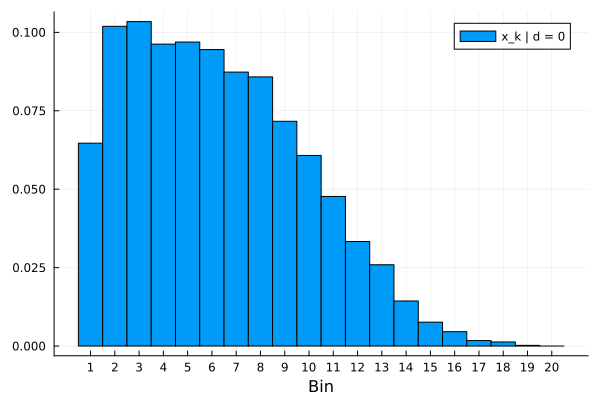

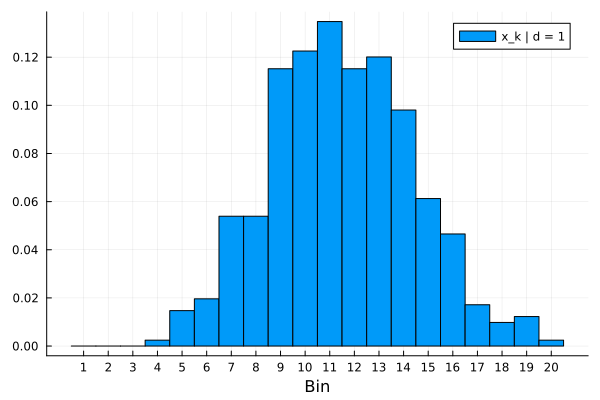

In [4]:
### Define variables

# Euler gamma
γ = Base.MathConstants.eulergamma

# Infer replacement (d = 1)
raw_df[!,:d] .= 0;
for t = 1:T-1
    raw_df[t,:d] = (raw_df[t+1,:mileage] < raw_df[t,:mileage]);
end

# Discretize
df, x_k = discretize(raw_df, K)

# Histogram of counts conditional on replacement
display(histogram(vec(df[df.d .=== 0,:].x),
            bins = 1:1:K+1, 
            normalize = true,
            xticks = (1.5:1:K+0.5, 1:1:K), 
            xlimits = (0,K+2),
            labels = "x_k | d = 0",
            xlabel = "Bin"));
display(histogram(vec(df[df.d .=== 1,:].x), 
            bins = 1:1:K+1, 
            normalize = true,
            xticks = (1.5:1:K+0.5, 1:1:K), 
            xlimits = (0,K+2),
            labels = "x_k | d = 1",
            xlabel = "Bin"));

In [5]:
# Construct transition matrix
function markov_mat(df, K)
    # Create columns representing indicators for next period bin, y
    col_names = []
    for k = 1:K
        df[!, "y_$k"] .= 0
        push!(col_names,"y_$k")
    end

    for t = 1:T-1
        y = df[t+1,:x]
        df[t,"y_$y"] = 1
    end

    # Calculate transition matrices, Π_d
    Π₁ = zeros(K,K)
    Π₀ = zeros(K,K)
    for x = 1:K
        for y = 1:K
            Π₁[x,y] = mean(df[(df.x .=== x) .& (df.d .=== 1), "y_$y"])
            Π₀[x,y] = mean(df[(df.x .=== x) .& (df.d .=== 0), "y_$y"])
        end
    end
    replace!(Π₁, NaN .=> 0.0)
    replace!(Π₀, NaN .=> 0.0)
    
    return Π₁, Π₀
end

markov_mat (generic function with 1 method)

In [6]:
### Create transition matrices
Π₁, Π₀ = markov_mat(df, K)

# Output matrices
display(Π₁)
display(Π₀)

20×20 Matrix{Float64}:
 0.0       0.0       0.0        0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0        0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0        0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0       0.0       0.0        0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.333333  0.666667  0.0        0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5       0.5       0.0        0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.545455  0.409091  0.0454545  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.772727  0.227273  0.0        0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.574468  0.404255  0.0212766  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.74      0.26      0.0        0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.745455  0.254545  0.0        0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.595745  0.382979  0.0212766  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.510204  0.469388  0.0204082  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.7       0.3 

20×20 Matrix{Float64}:
 0.107744  0.747475  0.141414  0.0       …  0.0        0.0       0.0  0.0
 0.0       0.228632  0.666667  0.102564     0.0        0.0       0.0  0.0
 0.0       0.0       0.244211  0.654737     0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.190045     0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0          0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0       …  0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0          0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0          0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0          0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0          0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0       …  0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0          0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0          0.0        0.0       0.0  0.0
 0.0       0.0 

In [7]:
# Nested fixed point algorithm 
function nfxp(θ)
    # Starting point
    EV₀ = ones(K)
    
    # Loop parameters
    err = 1000
    # Fixed point iterations
    while (err > tol)
        f = log.(exp(-θ[3] + β*EV₀[1]) .+ exp.(-θ[1].*x_k - θ[2].*(x_k ./ 100).^2 + β.*EV₀)) .+ γ
        EV₁ = Π₀ * f
        err = maximum(abs.(EV₁ - EV₀))
        EV₀ = EV₁
    end

    return EV₀
end

# Calculate conditional choice probability, Pr(d = 1 | x, θ)
function ccp(θ,EV)
    p = exp.(-θ[3] + β*EV[1]) ./ (exp.(-θ[3] + β*EV[1]) .+ exp.(-θ[1].*x_k - θ[2].*(x_k ./ 100).^2 .+ β.* EV))
    
    return p
end

# Evaluate likelihood
function likelihood(θ)
    # Compute value
    EV = nfxp(θ)
    
    # Compute conditional choice probabilities across states
    c = ccp(θ,EV)
    
    # Map conditional choice probabilities to data
    p = zeros(T)
    for t = 1:T
        p[t] = c[df[t,:x]]
    end
    d = vec(df[!,:d])

    # Return negative log-likelihood to minimize
    ll = sum(log.(p.^d .* (1 .- p).^(1 .- d)))
    
    return -ll
end

likelihood (generic function with 1 method)

In [8]:
### Solve model
β = 0.999;
params0 = zeros(3);

o = optimize(likelihood, params0, NelderMead())

 * Status: success

 * Candidate solution
    Final objective value:     1.050520e+03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   67  (vs limit Inf)
    Iterations:    203
    f(x) calls:    366


3-element Vector{Float64}:
 -5.504570006945734e-5
  0.4074802946717667
  6.596052494841001

20-element Vector{Float64}:
 8.39018224570386
 7.894338865370345
 7.274370374653404
 6.657584821784869
 6.122891158088475
 5.642460069158798
 5.173489509578111
 4.773091878193245
 4.400503274372884
 4.080803180833135
 3.810091025840556
 3.5704880690679204
 3.374783588714592
 3.188070481875674
 3.0478484214350714
 2.912635356410661
 2.8538008972276163
 2.6521042984542174
 2.388206521699052
 0.0

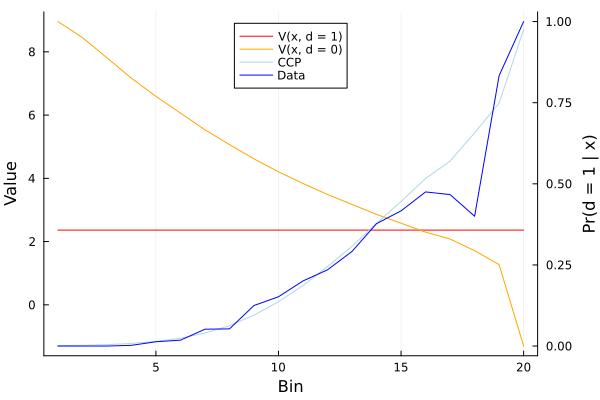

In [9]:
### Results

# Output estimates
θ = o.minimizer
display(θ)

latex_tabular("output/ps2_q3_estimates.tex",
              Tabular("ccc"),
              [[L"\theta_1", L"\theta_2", L"\theta_3"],
               Rule(:mid),
               round.(θ, digits=3),
               Rule(:bottom)]);

# Plot functions (Expected value, v_d, and CCP vs. data)
EV = nfxp(θ)
display(EV)

v_0 = -θ[1] .* x_k - θ[2] .* (x_k ./ 100).^2 .+ γ .+ β.*EV
v_1 = -θ[3] .* ones(K) .+ γ .+ β * EV[1]

c = ccp(θ,nfxp(θ))
d = combine(groupby(df, :x), :d .=> mean).d_mean

plt = plot([v_1, v_0], 
        legend = :top,
        labels = ["V(x, d = 1)" "V(x, d = 0)"], 
        color = [:red :orange],
        xlabel = "Bin",
        ylabel = "Value")
plot!([1:K, 1:K], [NaN.*(1:K), NaN.*(1:K)], 
    labels = ["CCP" "Data"], 
    linecolor=[:lightblue :blue], 
    legend=:top)
plot!(twinx(), [c, d], 
    ylabel = "Pr(d = 1 | x)", 
    linecolor=[:lightblue :blue],
    legend=false)
display(plt)
    
savefig("output/ps2_q3_rust_output.pdf");

In [10]:
### Sensitivity to binning

est_range = []
for k = 10:1:40
    K = k
    df, x_k = discretize(raw_df,K)
    Π₀ = markov_mat(df,K)[2]
    push!(est_range,optimize(likelihood, zeros(3), NelderMead()).minimizer)
end

1×3 Matrix{Float64}:
 -0.000236865  0.420953  6.68529

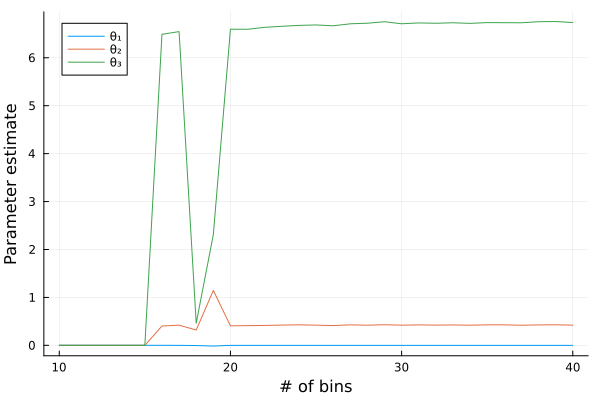

In [11]:
# Sensitivity plot
pl = reduce(hcat,est_range)'

display(mean(pl[pl[:,3] .> 5,:], dims = 1))

sens_plt = plot(10:1:40, [pl[:,1] pl[:,2] pl[:,3]], xlab = "# of bins", ylab = "Parameter estimate", labels = ["θ₁" "θ₂" "θ₃"])
display(sens_plt)

savefig("output/ps2_q3_sensitivity.pdf");